In [3]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [68]:
from xgboost import XGBClassifier

In [91]:
import mysql.connector
import pandas as pd

# Connect to your MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Qasim2004',
    database='stock_news'
)

# Load headlines with sentiment labels (adjust query as needed)
query = """
SELECT 
    headline, 
    sentiment_score, 
    confidence_score,
    matched_keywords,
    CASE 
        WHEN price_change_pct_24h > 0 THEN 1 
        ELSE 0 
    END AS label
FROM headlines
WHERE sentiment_score != 0
 AND price_change_pct_24h IS NOT NULL;
"""

df = pd.read_sql(query, conn)
conn.close()


# Preview
df.head()


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_18224/1615046114.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,headline,sentiment_score,confidence_score,matched_keywords,label
0,"Palantir Hit With Caution Flag, Citi Sees Risk...",-0.45,0.45,"down, slow",1
1,Why J.M. Smucker Stock Plummeted This Week,-1.00,1.00,plummeted,1
2,Meta Sues Crush AI to Block 'Nudify' Ads,-0.70,0.70,sue,1
3,This Wall Street pro did a deep dive into Tesl...,0.40,0.40,up,0
4,American Water Recognized for Excellence in Wa...,0.40,0.40,partnership,1


In [92]:
print(df.columns.tolist())


['headline', 'sentiment_score', 'confidence_score', 'matched_keywords', 'label']


In [93]:
# Feature: length of the headline
df['headline_length'] = df['headline'].apply(len)

# Feature: count of matched keywords (comma-separated string)
df['keyword_count'] = df['matched_keywords'].apply(
    lambda x: len(str(x).split(',')) if pd.notnull(x) else 0
)

In [110]:
df['label'] = df['price_change_pct_24h'].apply(lambda x: 1 if x > 1 else 0)


XGBoost

In [94]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [95]:
sentiment_dict = {

    # Strong positive (~1.0)
    "soars": 1.0, "surge": 1.0, "beat": 1.0, "growth": 0.95, "record": 1.0, "outperform": 1.0, 
    "tops": 0.9, "celebrates": 0.9, "profit": 0.95, "developing drug": 1.0,
    "developed immunotherapeutic drugs": 1.0, "genetic medicine development": 1.0, 
    "accelerating genetic medicine": 1.0, "more promising growth opportunities": 0.95,
    "record revenue": 1.0, "jumps": 0.8, "surges": 0.9, "breaks out": 0.8, "AI partnership": 0.7,
    "AI investment": 0.7, "approval": 0.7, "winning": 0.7, "greenlight": 0.7, "jumped": 0.6,
    "soared": 0.6,


    # Mild positive (~0.3 to 0.7)
    "gain": 0.6, "up": 0.4, "buy": 0.4, "strong": 0.6, "launch": 0.5, "debuts": 0.5, 
    "approve": 0.6, "positive": 0.5, "expands": 0.5, "rebranding": 0.3, "innovation": 0.6,
    "supporting inventory growth": 0.5, "financing agreement": 0.4, "debt payoff": 0.5,
    "material transfer agreement": 0.3, "potential acquisition": 0.5, "agreement to merge": 0.5,
    "seeks to merge": 0.4, "agreement with leading": 0.4, "acquire substantially": 0.5,
    "assumption agreement": 0.3, "acquire equity": 0.5, "premium": 0.6, "expansion": 0.5,
    "leading providers": 0.4, "predicting growth": 0.5, "reports growth": 0.5,
    "nasdaq regain compliance": 0.6, "balance sheet increase": 0.5, "total asset increase": 0.5,
    "asset increase": 0.5, "approval phase": 0.6, "pivotal phase": 0.5, "acquire": 0.5,
    "favorable safety": 0.6, "not side affect": 0.5, "visit casino": 0.3, "chinese stimulus": 0.6,
    "innovative ai": 0.6, "higher margin ads": 0.7, "goldman upgrade": 0.7, "morgan upgrade": 0.7,
    "brand leader": 0.5, "authorizing quarterly dividend": 0.6, "quarterly dividend": 0.5,
    "monetary stimulus": 0.7, "rate cuts": 0.5, "big cuts": 0.5, "research contract": 0.4,
    "advanced link terminals": 0.4, "focus digital platforms": 0.5, "investment": 0.4,
    "focus streaming platforms": 0.5, "promising growth": 0.5, "quantum contract award": 0.6,
    "ai force research": 0.6, "enhancing customer support": 0.5, "expanded service network": 0.4,
    "sufficient production capital": 0.5, "improve unit costs": 0.5, "mass production": 0.4,
    "smart device lineup": 0.5, "expansion smart device": 0.4, "interactive experience": 0.4,
    "help kids": 0.3, "make learning more": 0.4, "learning more engaging": 0.4,
    "enhance memory retention": 0.4, "additional earn-out payment": 0.4, "modernize": 0.4,
    "additional payment": 0.3, "owned subsidiary": 0.4, "accelerate business development": 0.6,
    "accelerate development": 0.6, "accelerate growth": 0.6, "proposed purchase price": 0.3,
    "non-binding proposal": 0.3, "pleased to announce": 0.5, "gold drilling completed": 0.4,
    "diamond drill completed": 0.4, "receiving a grant": 0.4, "develop technology": 0.5,
    "commercial agreement": 0.4, "supply alternative": 0.3, "successful launch": 0.6,
    "first income": 0.5, "strategic initiatives": 0.4, "purchase premium": 0.5,
    "growth equity": 0.6, "increased investment": 0.6, "enhancing long-term value": 0.6,
    "donation": 0.4, "partnership": 0.4, "donation and partnership": 0.5, "improves": 0.4,
    "social responsibility": 0.4, "strengthening public image": 0.4, "customer loyalty": 0.4,
    "positive brand awareness": 0.4, "community support": 0.5, "boosting user activity": 0.4,
    "won community": 0.4, "won award": 0.5, "reduce debt": 0.5, "monetizing asset": 0.4,
    "attractive cap": 0.4, "strong support": 0.4, "accelerating development": 0.6,
    "expand treatment": 0.5, "surplus": 0.5, "opens": 0.5, "rebound": 0.4, "boost": 0.5,
     "AI tools": 0.6, "cloud acceleration": 0.6, "first quarter results": 0.4, "agreement": 0.3, "adds": 0.3, 
    "incremental loan": 0.4,  "restructuring": 0.3, "opens facility": 0.4, "expands service": 0.5,
    "resume shipments": 0.4, "collaboration": 0.5, "surprise win": 0.6, "AI expansion": 0.6, "launches AI model": 0.5,
    "declares dividend": 0.3, "declares cash dividend": 0.4, "declares quarterly cash dividend": 0.4,
    "declares monthly cash dividend": 0.4, "dividend": 0.3, "cash dividend": 0.4, "quarterly dividend": 0.3, "monthly dividend": 0.3,
    "preferred dividend": 0.2, "distribution": 0.2, "declares distribution": 0.3, "regular dividend": 0.3, "income fund declares": 0.3,
    "partners with": 0.3, "help banks test AI tools": 0.4, "open its AI models": 0.3, "build first industrial AI cloud": 0.4,
    "maintains healthy fundamentals": 0.4, "attracts": 0.4, "broadens drone delivery service": 0.3, "secures": 0.3,
    "restarts shipments": 0.4, "achieves primary endpoint": 0.5, "bets big": 0.4, "digital makeover": 0.3, "revenue potential": 0.4,
    "expand into": 0.3, "preps overhaul": 0.3, "unveils": 0.2, "raises forecast": 0.4, "bull case for stocks": 0.4,
    "unlock real estate liquidity": 0.3, "highlighting strategic progress": 0.3, "first fully-licensed ai video model": 0.4,
    "strategic integration": 0.3, "enhance digital engagement": 0.3, "midyear outlook": 0.2, "pragmatic optimism": 0.3,
    "top 100 rankings": 0.3, "new numbers": 0.2, "releases strong earnings": 0.3, "releases new product": 0.3,
    "releases new model": 0.3, "releases new feature": 0.3, "releases beta version": 0.2, "releases cloud platform": 0.4,
    "releases software update": 0.3, "releases ai tool": 0.4, "releases guidance": 0.2, "achieves": 0.5, "potential": 0.2,
    "advance ai": 0.4, "thanks": 0.2, "appoints": 0.2, "jumping": 0.5, "climbs": 0.4, "soaring": 0.6, "ranks": 0.3,
    "increases stake": 0.4, "all-time high": 0.5, "grants": 0.2, "introduces": 0.3, "selected": 0.3, "rise": 0.3,
    "integration": 0.3, "grand opening": 0.3, "unveils new": 0.3, "sale": 0.2, "signs deal": 0.4, "new highs": 0.4,
    "restarts": 0.4, "stock repurchase program": 0.5, "acquisition": 0.4, "new corporate name": 0.1, "appoints chief financial officer": 0.2,
    "new cfo": 0.2,  "acquires": 0.4, "joint venture": 0.3, "solar installation": 0.3, "promotion": 0.2,
    "successful renewal": 0.4, "acquisition of infill portfolio": 0.4, "build a hospital": 0.4, "announces new chief": 0.2,



    # Strong Negative 
    "miss": -0.9, "misses": -0.9, "lawsuit": -0.8, "down": -0.6, "cut": -0.5, "recall": -0.8,
    "fall": -0.6, "drop": -0.8, "reverse stock split": -0.9, "restructuring layoffs": -0.8, 
    "executive exits": -0.6, "shareholder lawsuit": -0.9, "trading halted": -1.0, "releases disappointing earnings": -0.6,
    "loss": -0.9, "warns": -0.8, "delay": -0.6, "trap": -0.7,
    "fear": -0.5, "crash": -1.0, "struggle": -0.7, "negative": -0.5, "reverse split": -0.6,
    "compliance ruling": -0.5, "court compliance": -0.5, "layoffs": -0.9, "plummeted": -1.0,
    "fired": -0.9, "investigation": -0.8, "fraud": -1.0, "downgrade": -0.8,
    "short report": -0.7, "selloff": -0.9, "slump": -0.7, "decline": -0.6, "weakened": -0.6,
    "bankruptcy": -1.0, "insider trading": -1.0, "data breach": -0.9, "hacked": -0.8,
    "monopoly": -0.6, "sue": -0.7, "closed stores": -0.8, "delisting": -1.0, "plunges": -1.0, 
    "earnings miss": -0.8, "canceled contract": -0.9, "fined": -0.9, "legal challenge": -0.8,
    "slowing": -0.5, "concerns": -0.4, "delays": -0.6, "uncertainty": -0.5, "feud": -0.6, 
    "dispute": -0.6, "tariff impact": -0.6, "conflict": -0.6, "regulatory hurdles": -0.5, 
    "immigration raid": -0.7, "valuation trap": -0.7, "shutdown": -0.8, "stock looks like it's in trouble": -0.6,
    "releases fraud investigation results": -0.7, "releases bankruptcy statement": -1.0,
    "guidance cut": -0.7, "slashing forecast": -0.8, "warns of slowdown": -0.7, "disappoints investors": -0.6,
    "regulatory probe": -0.8, "investigation launched": -0.7, "ceo steps down": -0.6, "executive departure": -0.6,
    "missed expectations": -0.8, "pulls guidance": -0.8, "dividend suspended": -0.9, "cash burn": -0.7,
    "cutting workforce": -0.8, "restructuring plan": -0.5, "dilution": -0.6, "raises debt": -0.5, "revises outlook lower": -0.7,
    "sec charges": -1.0, "settles fraud charges": -0.9, "product defect": -0.8, "safety issue": -0.7, "delays product launch": -0.6,
    "cutting dividend": -0.8, "material weakness": -0.8, "trash": -0.6, "slashes": -0.6, "tumbles": -0.8, "proposes ban": -0.6,



    #Mild Negs
    "choppy market": -0.4, "anything but trash": -0.5, "being choppier": -0.3, "mulls sale of": -0.2, 
    "gloomy about economy": -0.4, "what the chart says may come next": -0.2,
    "releases weak guidance": -0.5, "releases layoffs plan": -0.4, "releases restated earnings": -0.6,
    "releases downward revision": -0.5, "under pressure": -0.3, "uncertain outlook": -0.4,
    "market headwinds": -0.3, "demand slowdown": -0.4, "weaker-than-expected": -0.4, "execution risk": -0.3,
    "missed deadline": -0.3, "volatile trading": -0.3, "slight miss": -0.3, "tumbles slightly": -0.3,
    "trimming forecast": -0.4, "elevated risk": -0.3, "market volatility": -0.3, "profit warning": -0.4,
    "underperformance": -0.3, "tightening conditions": -0.3, "revises outlook": -0.3, "sales below forecast": -0.4,
    "margins under pressure": -0.4, "rising costs": -0.3, "slower growth": -0.4, "falling short": -0.4, "guidance uncertainty": -0.3,
    "increased competition": -0.3, "fading": -0.3, "inflation": -0.4, "slow": -0.3, "all-time low": -0.5,
    "struggling": -0.6, "worries": -0.4, "new lows": -0.4, "maintains a hold rating": -0.2, "keeps a hold rating": -0.2,
    "reiterates a hold rating": -0.2, "closes public offering": -0.2, "reopening convertible notes": -0.3,
    "pricing of senior notes": -0.3, "debt refinancing": -0.2, "adjournment of annual meeting": -0.3,
    "reschedules earnings release": -0.3, "closing of secondary offering": -0.2, "liquidation of funds": -0.4,
    "senior unsecured notes": -0.3, "announces closing of secondary public offering": -0.3, "announces closing": -0.2,



    # Neutral/monitor for now (0.0)
    "casino": 0.0, "ai drama": 0.0, "china content": 0.0, "short platform": 0.0,
    "short drama": 0.0, 
}

In [96]:
def enrich_headline_features(df, sentiment_dict):
    def count_sentiment_keywords(text, sentiment_dict, polarity):
        matches = [
            word for word in sentiment_dict
            if word in text.lower() and (
                (polarity == "positive" and sentiment_dict[word] > 0)
                or (polarity == "negative" and sentiment_dict[word] < 0)
            )
        ]
        return len(matches)
    
    df["headline_length"] = df["headline"].apply(len)
    df["word_count"] = df["headline"].apply(lambda x: len(str(x).split()))
    df["contains_question_mark"] = df["headline"].apply(lambda x: "?" in str(x)).astype(int)
    df["contains_exclamation"] = df["headline"].apply(lambda x: "!" in str(x)).astype(int)
    df["num_positive_keywords"] = df["headline"].apply(lambda x: count_sentiment_keywords(x, sentiment_dict, "positive"))
    df["num_negative_keywords"] = df["headline"].apply(lambda x: count_sentiment_keywords(x, sentiment_dict, "negative"))
    return df


In [97]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Qasim2004',
    database='stock_news'
)

query = """
SELECT
  headline,
  sentiment_score,
  confidence_score,
  price_change_pct_24h
FROM headlines
WHERE sentiment_score IS NOT NULL
  AND price_change_pct_24h IS NOT NULL
"""


cursor = conn.cursor()
cursor.execute(query)
rows = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(rows, columns=columns)
conn.close()



In [98]:
# Add textual features using sentiment_dict
df = enrich_headline_features(df, sentiment_dict)


In [99]:
print(df.columns)


Index(['headline', 'sentiment_score', 'confidence_score',
       'price_change_pct_24h', 'headline_length', 'word_count',
       'contains_question_mark', 'contains_exclamation',
       'num_positive_keywords', 'num_negative_keywords'],
      dtype='object')


In [100]:
# Define features and target
features = ["sentiment_score", "headline_length", "word_count", "contains_question_mark",
            "contains_exclamation", "num_positive_keywords", "num_negative_keywords"]
target = "price_change_pct_24h"

X = df[features]
y = df[target]

# Convert to numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Drop any rows with NaNs
X = X.dropna()
y = y.loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("R^2 Score:", r2_score(y_test, y_pred))


RMSE: 4.448857103761354
R^2 Score: -0.9494051576630995


<Axes: >

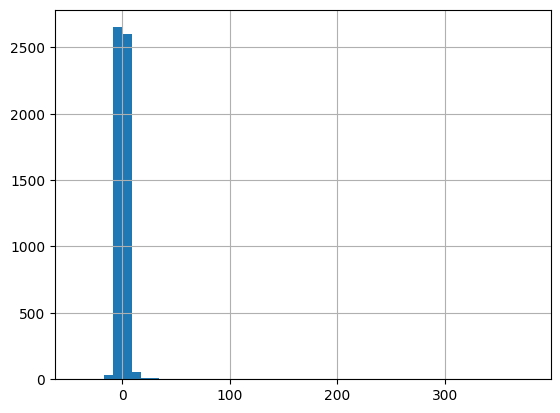

In [101]:
df['price_change_pct_24h'].hist(bins=50)


# -Random Forest Regressor (Experiment 2) 

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [103]:
# --- Random Forest Regressor ---
print("\n--- Random Forest Regressor ---")

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)

# Evaluate the model
import numpy as np
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

rf_r2 = r2_score(y_test, rf_preds)

print(f"RMSE: {rf_rmse:.4f}")
print(f"R^2 Score: {rf_r2:.4f}")



--- Random Forest Regressor ---
RMSE: 4.9604
R^2 Score: -1.4234


BINARY CLASSIFICATION

In [104]:
# Create binary label: 1 if price_change_pct_24h > 0, else 0
df['price_went_up'] = df['price_change_pct_24h'] > 0
df['price_went_up'] = df['price_went_up'].astype(int)


In [105]:
features = ["sentiment_score", "headline_length", "word_count", 
            "contains_question_mark", "contains_exclamation", 
            "num_positive_keywords", "num_negative_keywords"]

target = "price_went_up"

X = df[features]
y = df[target]


In [106]:
# ensure numeric values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y.loc[X.index]

# Train-test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [107]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
clf.fit(X_train, y_train)



# Predicting and evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5125815470643057

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.51      0.51       540
           1       0.51      0.51      0.51       533

    accuracy                           0.51      1073
   macro avg       0.51      0.51      0.51      1073
weighted avg       0.51      0.51      0.51      1073


Confusion Matrix:
 [[277 263]
 [260 273]]


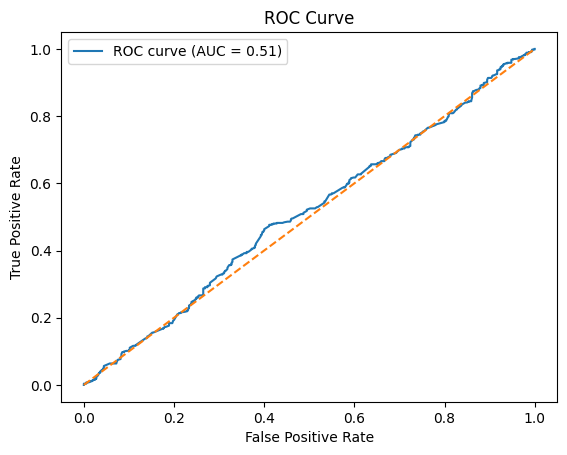

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)



plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define features/target
features = [
    "sentiment_score",
    "headline_length",
    "word_count",
    "contains_question_mark",
    "contains_exclamation",
    "num_positive_keywords",
    "num_negative_keywords"
]
X = df[features]
y = df['label']  # Binary label: 1 if >1% increase, else 0

#  Cleaning the numeric data
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[789   0]
 [284   0]]
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       789
           1       0.00      0.00      0.00       284

    accuracy                           0.74      1073
   macro avg       0.37      0.50      0.42      1073
weighted avg       0.54      0.74      0.62      1073



/Users/qasim/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/qasim/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/qasim/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)